In [36]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform
from scipy.spatial import KDTree


from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4566 rows x 9 columns]
Data shape:  (4566, 3)
Star ID (HIP):  

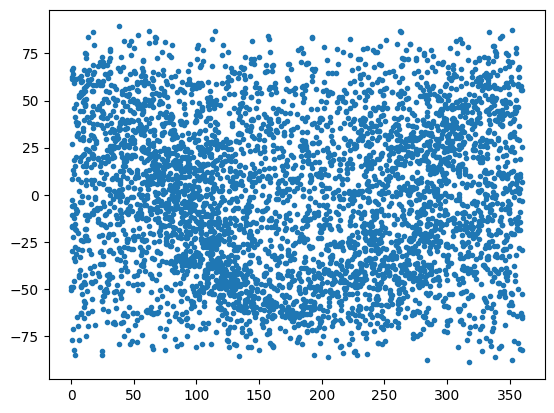

In [37]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID (HIP): ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [31]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []
# features_vec_3 = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    # center = np.mean(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], axis=0)
    # star_neighbors = stars_data[indices[i][0:n_of_neighbor+1]]
    # print("Neighbors:", star_neighbors[:,1:3])
    # print('Features:', get_star_features(star_neighbors[:,1:3], 1, 1, 1))

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")

        # #  Define the features vector that is going to be used in the SOM:

        # features_1.extend(log_polar_transform(stars_data[i][1], stars_data[i][2], stars_data[neighbor_index][1], stars_data[neighbor_index][2]) )
            
        # for k in range(1 +j-1,n_of_neighbor+1):
        #     features_2.append( np.sqrt( (stars_data[indices[i][k]][1] - stars_data[indices[i][j-1]][1])**2
        #                     +(stars_data[indices[i][k]][2] - stars_data[indices[i][j-1]][2])**2 )
        #                     ) 
    features_1, features_2 = get_star_features(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], 1, 1, 1)
    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)
    print('features_1: ', features_1)
    print('features_2: ', features_2)

    print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )
    print('----------------------')

Star ID: 14135.0 ( 45.569912 , 4.089921 )
Neighbor ID: 14143.0 ( 45.593785 , 4.352873 )
Neighbor ID: 14915.0 ( 48.109873 , 6.660885 )
Neighbor ID: 15457.0 ( 49.839787 , 3.369980 )
Neighbor ID: 15619.0 ( 50.278217 , 3.675680 )
features_1:  [-1.33168062  1.28482521  1.46560083  1.55318345  1.22798001  1.47207766
  1.55458617  1.31315452  1.30551857 -0.6264524 ]
features_2:  [0.26403315 3.61403621 4.33014412 4.7264928  3.41432565 4.35828078
 4.73312743 3.71788338 3.68960193 0.53448458]
Number of features:  10 , 10
----------------------
Star ID: 14143.0 ( 45.593785 , 4.352873 )
Neighbor ID: 14135.0 ( 45.569912 , 4.089921 )
Neighbor ID: 14915.0 ( 48.109873 , 6.660885 )
Neighbor ID: 15457.0 ( 49.839787 , 3.369980 )
Neighbor ID: 13954.0 ( 44.928738 , 8.907399 )
features_1:  [-1.33168062  1.22798001  1.47207766  1.52667005  1.28482521  1.46560083
  1.58102976  1.31315452  1.3595426   2.00167537]
features_2:  [0.26403315 3.41432565 4.35828078 4.6028241  3.61403621 4.33014412
 4.85995782 3.7178

Star ID: 12828.0 ( 41.234935 , 10.114216 )
Neighbor ID: 12832.0 ( 41.239628 , 12.445956 )
Neighbor ID: 12153.0 ( 39.157316 , 12.447840 )
Neighbor ID: 12148.0 ( 39.146259 , 7.730073 )
Neighbor ID: 13954.0 ( 44.928738 , 8.907399 )
features_1:  [0.84661668 1.13926392 1.15362243 1.35736703 0.7334792  1.64086425
 1.63155968 1.55133839 1.91262258 1.77514137]
features_2:  [2.33174444 3.12446767 3.16965397 3.88594822 2.0823128  5.15962682
 5.11184133 4.71778018 6.77082253 5.90111532]
----------------------


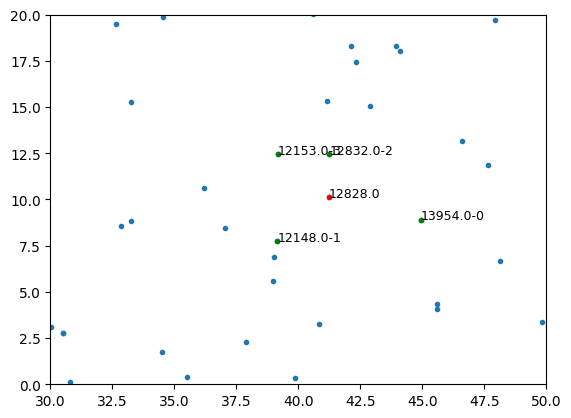

In [32]:
# Search the neighbors of a specific star

stars_sublist = [12828]

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):

    if stars_data[i][0] in stars_sublist:
        print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

        neihgtbors_list = []
        for j in range(1,n_of_neighbor+1):
            neighbor_index = indices[i][j]
            print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")
            neihgtbors_list.append(stars_data[neighbor_index][0])

        # features_vec_3.append(features_3)
        print('features_1: ', features_vec_1[i])
        print('features_2: ', features_vec_2[i])
        print('----------------------')

        plt.figure()
        plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

        plt.plot(stars_data[i,1],stars_data[i,2],'.r')
        plt.text(stars_data[i,1], stars_data[i,2], stars_data[i,0], fontsize=9)

        stars_subdata = stars_data[np.where(np.isin(stars_data[:,0], neihgtbors_list))]
        plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
        #Plot the identification names of the sub set of stars
        for i in range(len(stars_subdata)):
            plt.text(stars_subdata[i,1], stars_subdata[i,2], str(stars_subdata[i,0]) + '-' + str(i), fontsize=9)

        #change the limits of the axis
        plt.xlim([30, 50])
        plt.ylim([0, 20])

        plt.show()  

In [33]:

## SINGLE TRAINING ##

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# mesh_size = int(np.sqrt(features_1_n.shape[0])/2)
# Manual set 

# hyperparameters = {
#     'mesh_size_1': 66,
#     'mesh_size_2': 67,
#     'sigma': 3.41841785914334,
#     'learning_rate': 0.25626770637847895,
#     'neighborhood_function': 'triangle',
#     'topology': 'hexagonal',
#     'activation_distance': 'euclidean',
# }

hyperparameters = {'mesh_size_1': 68, 'mesh_size_2': 68, 'sigma': 3.263122498850444, 'learning_rate': 0.7894422310231358, 'neighborhood_function': 'triangle', 'topology': 'rectangular', 'activation_distance': 'euclidean'}

# Initialize the SOM
som1 = MiniSom(
    x = hyperparameters['mesh_size_1'],
    y = hyperparameters['mesh_size_1'],
    input_len = features_1_n.shape[1],

    sigma=hyperparameters['sigma'],
    learning_rate=hyperparameters['learning_rate'],
    neighborhood_function=hyperparameters['neighborhood_function'],
    topology=hyperparameters['topology'],
    activation_distance=hyperparameters['activation_distance']

)

som2 = MiniSom(
    x = hyperparameters['mesh_size_2'],
    y = hyperparameters['mesh_size_2'],
    input_len = features_2_n.shape[1],

    sigma=hyperparameters['sigma'],
    learning_rate=hyperparameters['learning_rate'],
    neighborhood_function=hyperparameters['neighborhood_function'],
    topology=hyperparameters['topology'],
    activation_distance=hyperparameters['activation_distance']
)

print(f"SOM 1 size = {hyperparameters['mesh_size_1']} x {hyperparameters['mesh_size_1']} = {hyperparameters['mesh_size_1']**2}")
print(f"SOM 2 size = {hyperparameters['mesh_size_2']} x {hyperparameters['mesh_size_2']} = {hyperparameters['mesh_size_2']**2}")

# Train the SOM
som1.train_random(data=features_1_n, num_iteration=50000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=50000, verbose= True)



/home/ignaciozm/.local/lib/python3.10/site-packages/minisom.py:205: UserWarning: sigma should be an integer >=1 when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer >=1 when triangle or bubble' +


SOM 1 size = 68 x 68 = 4624
SOM 2 size = 68 x 68 = 4624
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.03572982244898819
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.03436105894742289


In [34]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
star_dict_2

Number of neurons with data: 3154 ; Total neurons: 4624
Number of neurons with data: 3174 ; Total neurons: 4624


{(44, 15): [0],
 (36, 56): [1, 3779],
 (41, 2): [2, 3983],
 (58, 56): [3, 2447],
 (15, 42): [4],
 (6, 6): [5, 1058],
 (37, 67): [6, 1141, 4121],
 (48, 59): [7, 4360],
 (7, 62): [8, 1103, 1258, 1259, 2821],
 (21, 35): [9, 1611],
 (16, 49): [10, 2967],
 (16, 44): [11, 2008],
 (37, 43): [12, 4491],
 (6, 1): [13],
 (59, 35): [14, 4464],
 (25, 64): [15],
 (16, 12): [16],
 (38, 54): [17],
 (0, 37): [18, 523],
 (1, 37): [19, 2207],
 (10, 9): [20, 861, 862],
 (67, 19): [21],
 (40, 14): [22],
 (61, 32): [23, 1104],
 (46, 44): [24],
 (63, 13): [25, 237, 1301],
 (9, 1): [26, 2603],
 (63, 3): [27, 4155, 4166],
 (58, 3): [28, 3305, 3307, 3604, 4162],
 (61, 4): [29, 30],
 (45, 65): [31, 4022],
 (13, 10): [32, 33],
 (47, 67): [34, 4560],
 (6, 41): [35],
 (16, 51): [36],
 (21, 41): [37, 2288],
 (21, 40): [38],
 (56, 0): [39, 49, 2138, 3193],
 (57, 0): [40, 2133, 2134, 2135, 2136],
 (59, 0): [41, 42, 44, 50, 53],
 (58, 0): [43, 1879],
 (3, 15): [45, 3661],
 (6, 44): [46],
 (58, 1): [47, 48, 1884, 1885,

In [63]:
import pickle

mesh_size = hyperparameters['mesh_size_1']

name = 'n'+ str(mesh_size) +'_tycho' + catalog_path[-5:-4]

# Create a directory to save the SOM parameters
if not os.path.exists('../data/SOM_parameters/'+ name):
    os.makedirs('../data/SOM_parameters/'+ name)

# saving the som in the file som.p
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'wb') as outfile:
    pickle.dump([som1, som2], outfile)

# Save normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + catalog_path[-5:-4] + '.p', 'wb') as outfile:
    pickle.dump([features_vec_1.min(axis=0), features_vec_1.max(axis=0), features_vec_2.min(axis=0), features_vec_2.max(axis=0)], outfile)

# Save dictionario of neurons to star
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'wb') as outfile:
    pickle.dump([star_dict_1, star_dict_2], outfile)


In [27]:
# # Load the SOM
# with open('../data/SOM_parameters/som1_210124.p', 'rb') as infile:
#     som1 = pickle.load(infile)

# with open('../data/SOM_parameters/som2_210124.p', 'rb') as infile:
#     som2 = pickle.load(infile)


# # # Load normalization parameters
# with open('../data/SOM_parameters/normalization_parameters_210124.p', 'rb') as infile:
#     norm_param = pickle.load(infile)

# print(norm_param)

[array([-102.68617306,   -8.91525361,  -93.38599334,   -9.43216694,
       -102.46856945,   -9.04852306,  -93.02568472,   -9.34836194]), array([56.59544139, 66.24432444, 59.92603   , 67.60059666, 78.69598722,
       66.21109139, 88.64100778, 67.12397   ]), array([0.01174987, 0.02991307, 0.01195341, 0.03364374, 0.01195341,
       0.01174987, 0.01195341, 0.01174987, 0.01195341, 0.02790013]), array([102.72772982,  93.55459926, 102.55032236,  93.12497215,
       103.02215357, 108.23763576, 107.05727554,  48.51657168,
        45.35523759,  62.08988073])]


In [61]:
# stars_data['HIP=12828']

# Search in stars_data[0] the star with HIP = 12828


12

SOM1: Predicted Stars ID: [1455, 2575]
SOM2: Predicted Stars ID: [1455, 2575]
Final guess: 2779, actual star ID: 2575


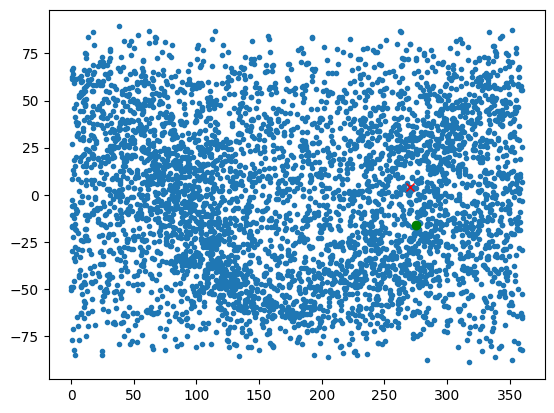

In [57]:
# Define a function to predict the star ID for a given feature vector
def predict_star_id(features, features_array, dictionary, som):
    normalized_feature = (features - features_array.min(axis=0)) / (features_array.max(axis=0) - features_array.min(axis=0))
    winner = som.winner(normalized_feature)
    if winner in dictionary:
        return dictionary[winner]
    else:
        return [0] #The neuron has no star ID return [0], the ID start at 1 
    
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))
# random_id = np.where(stars_data[:,0] == 12828)[0][0] # To check the prediction of a specific star (not that random)

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guess: {star_guess}, actual star ID: {random_id}")

plt.figure()
plt.plot(stars_data[:,1],stars_data[:,2],'.')
plt.plot(stars_data[random_id][1],stars_data[random_id][2],'og')
plt.plot(stars_data[star_guess][1],stars_data[star_guess][2],'xr')
plt.show()


In [58]:
import time 

cont = np.zeros(3) # [Correct match, miss match, multiple match]
mean_noise = 0

time_start = time.time()
for i in range(features_vec_1.shape[0]):

    # Itroduce noise in the features vector to check the response of the SOM
    scale = 0.005 # % respect max value 

    noise_1 = np.random.normal(loc=0, scale=1, size=features_vec_1.shape[1])*np.max(features_vec_1[i])*scale
    noise_2 = np.random.normal(loc=0, scale=1, size=features_vec_2.shape[1])*np.max(features_vec_2[i])*scale
    sample_feature_1= features_vec_1[i] - noise_1
    sample_feature_2= features_vec_2[i] - noise_2

    mean_noise += np.mean( np.abs(noise_1)/features_vec_1[i] ) + np.mean( np.abs(noise_2)/features_vec_2[i] ) 

    predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
    predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))
    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) == 1:
        cont[0] += star_guess[0] == i
    else:
        # print("Error: ", list(set(predicted_star_ids_1).intersection(predicted_star_ids_2)), "!=", i)
        cont[1] += len(star_guess) == 0
        cont[2] += len(star_guess) > 1
time_end = time.time()

mean_noise = mean_noise / features_vec_1.shape[0] / 2
print('number of cases:', np.sum(cont))
print("mean noise level=",  mean_noise)
print("total success =",  cont / features_vec_1.shape[0])
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / features_vec_1.shape[0])


number of cases:
mean noise level= 4563.0
total success = [0.76982041 0.01073149 0.21879106]
total time= 6.918245315551758
total time per star= 0.0015151654217152339
